In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

product_name_trans = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\product_category_name_translation.csv")
seller = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_sellers_dataset.csv")
products = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_products_dataset.csv")
orders = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_orders_dataset.csv")
order_reviews = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_reviews_dataset.csv")
order_payments = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_payments_dataset.csv")
order_items = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_order_items_dataset.csv")
geolocation = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_geolocation_dataset.csv")
customers = pd.read_csv(r"C:\Users\Tuan Nguyen\Desktop\Brazilian ecommerce\olist_customers_dataset.csv") 

The data is duplicated in some files. For example, in **order_reviews** we have duplicated items in *order_id* column (i.e. customers can write reviews for several items in one order). Therefore, we should be careful before merging the files.

In [2]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


## Question 1:What was the platform's performance in the last 2 years?

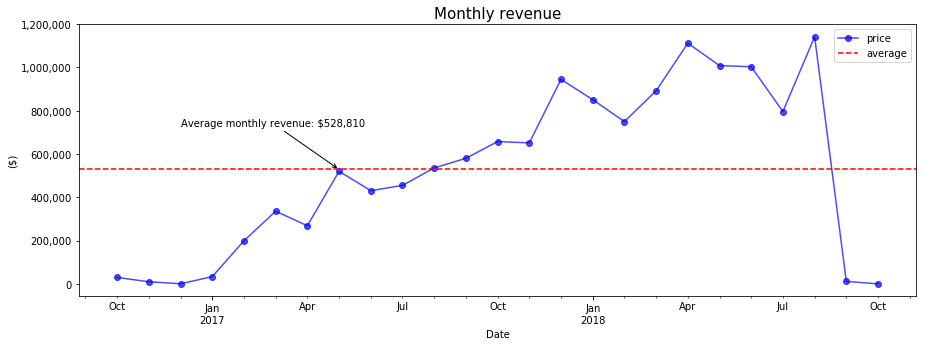

In [3]:
#Merge 2 dataframe orders and order_items 
data = orders.merge(order_items, left_on = 'order_id', right_on = 'order_id', how ='left', indicator = True)
data['order_delivered_customer_date'] = pd.to_datetime(data.order_delivered_customer_date)

#Remove rows with no information of delivery date and set delivered date as index
data1 = data[~data.order_delivered_customer_date.isna()]\
             .rename(columns = {'order_delivered_customer_date':'Date'}).set_index('Date').sort_index()

#We only count delivered products since they will be booked as revenue (regardless of payment status)
data_revenue_monthly = data1.query('order_status == "delivered"').resample('M').agg({'price':'sum'})
avg_revenue_monthly = data_revenue_monthly.price.mean()

#Plot using matplotlib
fig, ax = plt.subplots(figsize = (15,5))
data_revenue_monthly.plot(ax = ax, style = 'bo-', label ='Revenue', alpha = 0.7, )
ax.set_title('Monthly revenue', fontsize =15)
ax.axhline(avg_revenue_monthly, color ='r', linestyle ='--', label = 'average')
ax.legend()
ax.set_ylabel('($)')

#Format y-axis using (,) as thousands separator
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#Plot annotation
ax.annotate(f'Average monthly revenue: ${avg_revenue_monthly:,.0f}', xy = ('2017-05-01', avg_revenue_monthly)\
             , xytext = ('2016-12-01', avg_revenue_monthly + 200000), arrowprops = dict(arrowstyle = '->'))
plt.show()

## Question 2: How much freight costs incurred in the last 2 years? 

We can see that for each sold item will be recored separately in a single row. That is why for **one order_id with multiple items**, the freight costs were recorded seperately for each item. Even the items which were sold from the same seller in the same order will have different costs (unless they are the same items or in other words having the **same product_id**). In addition, there are some cases that freight_value is higher than price. Therefore, we can assume that a seller will ship its products together and charged the whole package ***only one time and using the highest freight_value***. In this question, we will use seaborn to plot.

In [4]:
#Order with multiple items
data1.query('order_id == "a98012aa8c697f2bcff9f8c2183e0f2b"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,_merge
Date,,,,,,,,,,,,,,
2018-05-18 22:46:45,a98012aa8c697f2bcff9f8c2183e0f2b,3e337c99e0f5ff7ba9a4b98fbf7412fd,delivered,2018-05-13 22:50:32,2018-05-13 23:11:49,2018-05-14 11:49:00,2018-06-01 00:00:00,5.0,643a66b1dc5dad3de6cb5a41549e72f1,cb6c9f5888a7a090c75beaf615925792,2018-05-17 23:11:49,29.95,7.84,both
2018-05-18 22:46:45,a98012aa8c697f2bcff9f8c2183e0f2b,3e337c99e0f5ff7ba9a4b98fbf7412fd,delivered,2018-05-13 22:50:32,2018-05-13 23:11:49,2018-05-14 11:49:00,2018-06-01 00:00:00,1.0,c5cb254d666e4420d56b5dc67ff59d29,52f0fe436a347ddad7ed5f9aa4e27eaa,2018-05-17 23:11:49,8.99,23.51,both
2018-05-18 22:46:45,a98012aa8c697f2bcff9f8c2183e0f2b,3e337c99e0f5ff7ba9a4b98fbf7412fd,delivered,2018-05-13 22:50:32,2018-05-13 23:11:49,2018-05-14 11:49:00,2018-06-01 00:00:00,3.0,c6e513054b982283c1cbbb2a45d02d83,f8db351d8c4c4c22c6835c19a46f01b0,2018-05-15 23:11:49,22.90,0.78,both
2018-05-18 22:46:45,a98012aa8c697f2bcff9f8c2183e0f2b,3e337c99e0f5ff7ba9a4b98fbf7412fd,delivered,2018-05-13 22:50:32,2018-05-13 23:11:49,2018-05-14 11:49:00,2018-06-01 00:00:00,4.0,c5cb254d666e4420d56b5dc67ff59d29,52f0fe436a347ddad7ed5f9aa4e27eaa,2018-05-17 23:11:49,8.99,23.51,both
2018-05-18 22:46:45,a98012aa8c697f2bcff9f8c2183e0f2b,3e337c99e0f5ff7ba9a4b98fbf7412fd,delivered,2018-05-13 22:50:32,2018-05-13 23:11:49,2018-05-14 11:49:00,2018-06-01 00:00:00,2.0,c5cb254d666e4420d56b5dc67ff59d29,52f0fe436a347ddad7ed5f9aa4e27eaa,2018-05-17 23:11:49,8.99,23.51,both


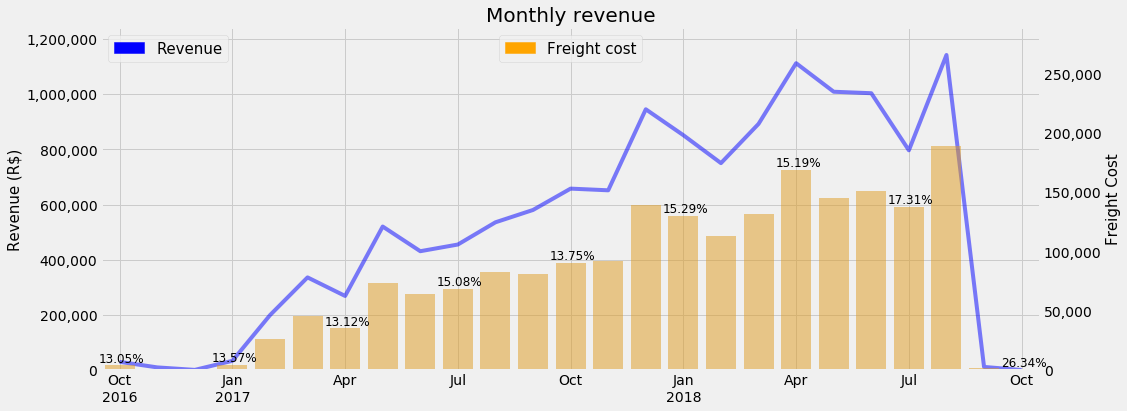

In [5]:
#Prepare data, group date index, order_id and seller_id to derive the highest freight values of each seller in each order 
data_delivered = data1.query('order_status == "delivered"')
data_delivered_adj = pd.DataFrame(data_delivered.groupby([pd.Grouper(freq = '1D'), 'order_id','seller_id']).freight_value.max())

#Because the data now has MultipleIndex, we need to reset_index to unstack first and then continue resampling by month
data_delivered_plt = data_delivered_adj.reset_index().set_index('Date').resample('M').agg({'freight_value' : 'sum'})

#Use mpatches to fix the bug when plotting 2 y-axis at different scales
import matplotlib.patches as mpatches

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize = (15,7))

ax1 = sns.lineplot(x = data_revenue_monthly.index.strftime('%b\n%Y'),\
                  y = 'price', data = data_revenue_monthly, color ='blue', sort = False, alpha = 0.5)
ax1.set_title('Monthly revenue', fontsize =20)
ax1_patch = mpatches.Patch(color='blue', label ='Revenue')
ax1.legend(handles = [ax1_patch], loc = "upper left", fontsize = 15)
ax1.set_ylabel('Revenue (R$)', fontsize = 15)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#Adjust ylim to have a nice plot
ax1.set_ylim(0, data_revenue_monthly.price.max() +100000)

#It is important to make a twin for plotting the 2nd y-axis
ax2 = ax1.twinx()
ax2 = sns.barplot(x = data_delivered_plt.index.strftime('%b\n%Y'), y ='freight_value', data = data_delivered_plt,\
                  color = 'orange', alpha = 0.5)
#Remove grid to avoid crash when plotting
ax2.grid(b=False)
ax2.set_ylabel('Freight Cost', fontsize = 15)
#Use mpatches to plot the legend of 2nd y-axis
ax2_patch = mpatches.Patch(color='orange', label ='Freight cost')
ax2.legend(handles = [ax2_patch], loc = "upper center", fontsize = 15)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylim(0,data_delivered_plt.freight_value.max()+100000)

#Plot the percentages of monthly freight costs on monthly revenues
#Important: we only use freight_value.values to avoid the crash when formatting the percentages 
#(because Series doesn't accept format function)
percentages = data_delivered_plt.reset_index().freight_value.values/data_revenue_monthly.reset_index().price.values

#Using [::3] to avoid a crowded bar plot 
patches = ax2.patches
for i in range(len(patches))[::3]:
    x = patches[i].get_x() + patches[i].get_width()/2 + 0.05
    y = patches[i].get_height() + 3000
    ax2.annotate(f'{100*percentages[i]:,.2f}%', xy = (x, y), ha ='center', fontsize = 12)

#Create tick labels to avoid a crowded bar plot
timestamps = data_delivered_plt.index[::3]
#Avoid ploting too many years in y-axis
labels = [ts.strftime('%b\n%Y') if ts.year != timestamps[idx-1].year
          else ts.strftime('%b') for idx, ts in enumerate(timestamps)]

# Set major ticks and labels
ax.set_xticks([data_delivered_plt.index.get_loc(ts) for ts in timestamps])
ax.set_xticklabels(labels)

# Set minor ticks without labels
ax.set_xticks([data_delivered_plt.index.get_loc(ts) for ts in data_delivered_plt.index], minor=True)

# Rotate and center labels
ax.figure.autofmt_xdate(rotation=0, ha='center')
plt.show()


## Question 3: Which is customers' ordering pattern ? 

To answer this question, we will plot 2 graphs. One is for total number of orders by Day of Week (e.g. Monday, Friday) and one is for the time customer made their purchases (e.g. Morning, Evening).

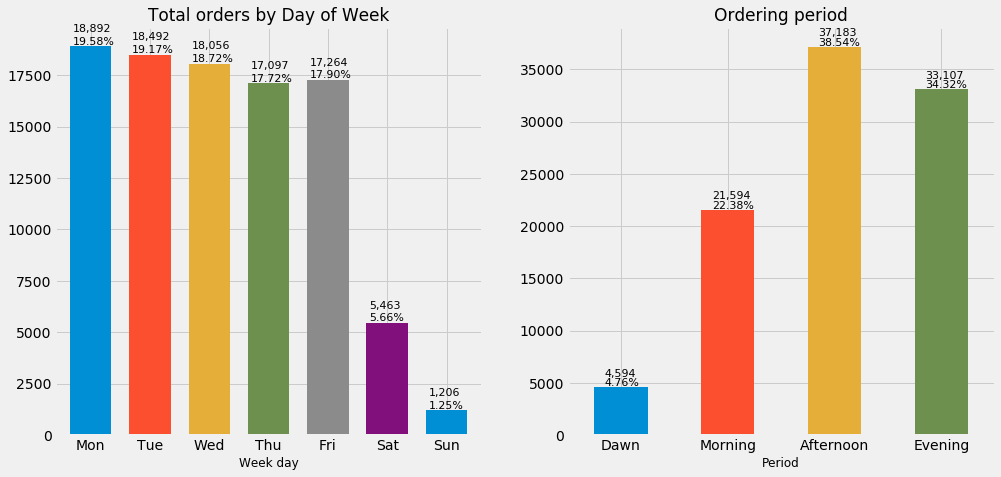

In [6]:
#Prepare data for ploting total orders by Day of Week
data3 = orders.copy()
data3['order_delivered_customer_date'] = pd.to_datetime(data3.order_delivered_customer_date)
data3 = data3[~(data3.order_delivered_customer_date.isna()) & (data3.order_status == 'delivered')]\
                .rename(columns = {'order_delivered_customer_date':'Date'}).set_index('Date').sort_index()

#Sort the x-axis using reindex() method
cats = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
data3_plt = data3.assign(weekday = data3.index.strftime('%a')).groupby('weekday').size().reindex(cats)

#Prepare data for ploting purchase period
data4 = orders.copy()
data4 = data4[~(orders.order_purchase_timestamp.isna()) & (orders.order_status == 'delivered')]\
            .rename(columns = {'order_purchase_timestamp':'Date'}).set_index('Date').sort_index()

data4_plt = data4.assign(time = pd.cut(pd.to_datetime(data4.index).hour, \
                                   bins = [0, 6, 12, 18, 24], \
                                   labels = ['Dawn', 'Morning', 'Afternoon', 'Evening'], right = False))\
                    .groupby('time').size()

#Plotting
fig, ax = plt.subplots(1,2, figsize = (15,7))

data3_plt.plot(kind ='bar', rot = 0, width = 0.7, ax = ax[0])
ax[0].set_title('Total orders by Day of Week', fontsize = 17)
ax[0].set_xlabel('Week day', fontsize = 12)

for i in range(len(data3_plt)):
    total_order = data3_plt.sum()
    height = data3_plt[i]
    ax[0].annotate(f'{height:,.0f}', xy = (i-0.3, height + 700), fontsize = 11)
    ax[0].annotate(f'{height/total_order*100:,.2f}%', xy = (i-0.3, height + 100), fontsize = 11)

data4_plt.plot(kind = 'bar', rot = 0, width = 0.5, ax = ax[1])
ax[1].set_title('Ordering period', fontsize = 17)
ax[1].set_xlabel('Period', fontsize = 12)

for i in range(len(data4_plt)):
    total_order = data4_plt.sum()
    height = data4_plt[i]
    ax[1].annotate(f'{height:,.0f}', xy = (i - 0.15, height + 1000), fontsize = 11)
    ax[1].annotate(f'{height/total_order*100:,.2f}%', xy = (i - 0.15, height + 100), fontsize = 11)
    
plt.show()

## Question 4: What are top 10 most sold product (in R$)?

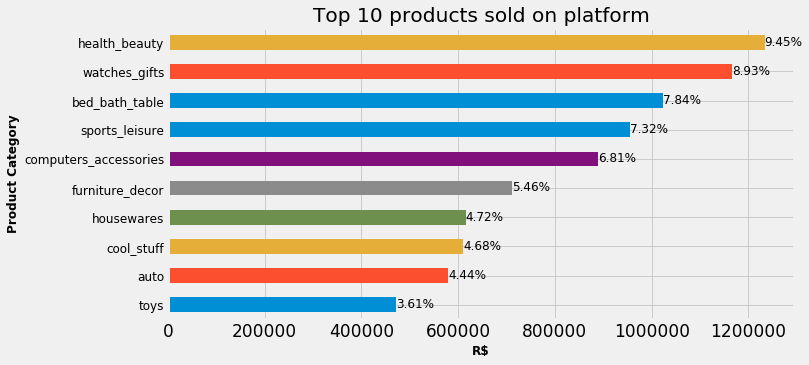

In [7]:
#Merge products and its translations files 
product_category = products.merge(product_name_trans, left_on = 'product_category_name', \
                                  right_on = 'product_category_name', how = 'left', indicator = True)

product_category.dropna(subset = ['product_category_name'], inplace = True)

#There are some product categories which don't exist in translation file
product_category['product_category_name_english'] = [x if not pd.isnull(x) \
                                                     else product_category['product_category_name'][i] \
   for i, x in enumerate (product_category['product_category_name_english'])]

#Merge data1 and product_category files
data5 = data1.merge(product_category[["product_id","product_category_name_english"]],\
            left_on = 'product_id', right_on = 'product_id', how ='left')

data5_plt = data5.groupby('product_category_name_english')['price'].sum().sort_values(ascending = False)

from matplotlib import cm
#Plotting
fig, ax = plt.subplots(figsize = (10,5))
data5_plt[:10].sort_values().plot(kind = 'barh', title = 'Top 10 products sold on platform', fontsize = 17, ax =ax)
ax.set_ylabel('Product Category', fontsize = 12, weight = 'bold')
ax.set_xlabel('R$', fontsize =12, weight = 'bold')
plt.yticks(fontsize = 12)

for i in range(10):
    total_revenue = data5_plt.sum()
    width = data5_plt[:10].sort_values()[i]
    ax.annotate(f'{width/total_revenue*100:,.2f}%', xy = (width + 100, i -0.1), fontsize = 12)
    
plt.show()

In [8]:
data1.index.year

Int64Index([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
            ...
            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
           dtype='int64', name='Date', length=110196)

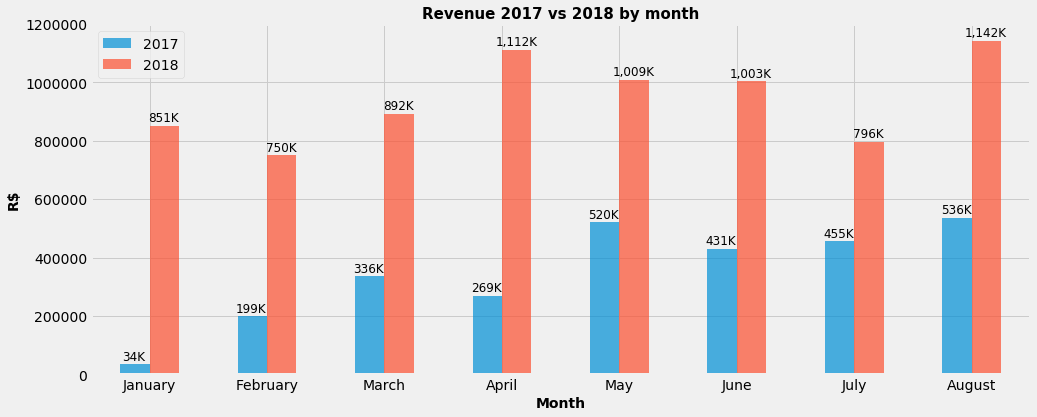

In [9]:
data1_part1 = data1['2017-01':'2017-08'] 
data1_part2 = data1['2018-01':'2018-08']
data6 = pd.concat([data1_part1, data1_part2])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']

data6_plt = data6.assign(month = lambda x: x.index.month_name(), year = lambda x: x.index.year)\
                .groupby(['month','year'])['price'].sum().unstack().reindex(month_order)

fig, ax = plt.subplots(figsize = (15,6))
width = 0.5
data6_plt.plot(kind = 'bar', ax = ax, rot = 0, alpha = 0.7, width = width)
ax.set_title('Revenue 2017 vs 2018 by month', fontsize = 15, weight ='bold')
ax.set_ylabel('R$', fontsize = 14, weight = 'bold')
ax.set_xlabel('Month', fontsize = 14, weight = 'bold')
ax.legend(['2017', '2018'], fontsize = 14 )
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)

adj = 0
for y in range(2):
    for m in range(len(data6_plt)):
        total_rev = data6_plt.iloc[:, y].sum()
        height = data6_plt.iat[m, y]
        ax.annotate(f'{round(height)/1000:,.0f}K', xy = (m + width/2, height)\
                    , xytext = (-45 + adj, 8), fontsize = 12, textcoords = 'offset points', ha ='center', va ='center')
    adj += 30       


In [10]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
